In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn
import biophysnn_raytune
import bindingdata

from importlib import reload

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Analysis

RBP = "HNRNPA1"
rep = "_rep1"

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
config = {
 'RBP' : RBP,  
 'rep' : rep,
 "conc" : 50, 
 "binding_threshold" : 3, 
 'batch_size': 100,
 'dropout': 0.1, 
 'depth': 3,
 'first_filter_width': tune.choice([7,9,11]),
 'filter_width' : tune.choice([3,5,7]), 
 'first_pool_stride' : tune.randint(4,9), 
 'pool_stride' : tune.randint(2,5), 
 'pool_overlap' : tune.randint(3,6),
 'lr': 1e-3,
 'n_channel': 32,
 'n_hidden' : 64,
 'weight_decay': 0.,
 'avgpool' : [False,False] ,
 'exp_log' : [False,False] , 
 'num_chunks' : tune.choice([5,7,9,11,13]),
 'min_seq_len' : 300, 
 'max_seq_len' : 1500
}

try: 
    result = tune.run(
        biophysnn_raytune.Trainable,
        config = config,
        reuse_actors = True, 
        name = "tuneCNN_%s" % RBP, 
        num_samples=60,
        checkpoint_freq=1,
        progress_reporter = tune.JupyterNotebookReporter( # limit console output
            overwrite = True, 
            max_report_frequency = 1000, 
            max_progress_rows = 1, 
            max_error_rows = 1
        ),
        scheduler = ASHAScheduler(
            max_t=30, 
            grace_period=3), 
        resources_per_trial={'gpu': 1} if torch.cuda.is_available() else {"cpu": 28, "gpu": 0},
        metric="val_auroc", # metric to optimize
        mode="max"
    )
except tune.error.TuneError: 
    print("TuneError... shucks")

Trial name,status,loc,filter_width,first_filter_width,first_pool_stride,num_chunks,pool_overlap,pool_stride
Trainable_8e993_00000,RUNNING,,5,11,4,5,5,3


2022-09-03 14:09:39,742	WARNING worker.py:1034 -- The actor or task with ID ffffffffffffffff88866c7d01000000 cannot be scheduled right now. It requires {CPU: 28.000000} for placement, but this node only has remaining {node:10.4.200.67: 1.000000}, {object_store_memory: 43.505859 GiB}, {memory: 137.792969 GiB}. In total there are 0 pending tasks and 2 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


In [3]:
analysis = Analysis("/gpfs/commons/home/daknowles/ray_results/tuneCNN_%s" % RBP)

analysis.get_best_config("val_auroc","max")

{'RBP': 'HNRNPA1',
 'avgpool': [False, False],
 'batch_size': 100,
 'binding_threshold': 3,
 'conc': 50,
 'depth': 3,
 'dropout': 0.1,
 'exp_log': [False, False],
 'filter_width': 3,
 'first_filter_width': 7,
 'first_pool_stride': 5,
 'lr': 0.001,
 'max_seq_len': 1500,
 'min_seq_len': 300,
 'n_channel': 32,
 'n_hidden': 64,
 'num_chunks': 13,
 'pool_overlap': 4,
 'pool_stride': 4,
 'rep': '_rep1',
 'weight_decay': 0.0}

In [4]:
df = analysis.dataframe()
df
#df.val_auroc.max()

,val_loss,val_acc,val_auroc,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,config/max_seq_len,config/min_seq_len,config/n_channel,config/n_hidden,config/num_chunks,config/pool_overlap,config/pool_stride,config/rep,config/weight_decay,logdir
0,0.420021,0.809747,0.890547,True,NaN,NaN,3,40b6b_00018,3cd8be561e454aa58806fe98ca597de7,2022-09-03_12-36-53,...,1500,300,32,64,13,5,2,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
1,0.410067,0.814725,0.898549,True,NaN,NaN,3,40b6b_00007,7766c088464d4631b2182e6874314cd4,2022-09-03_03-17-25,...,1500,300,32,64,13,3,3,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
2,0.426754,0.808041,0.897798,True,NaN,NaN,3,40b6b_00003,7766c088464d4631b2182e6874314cd4,2022-09-02_20-45-52,...,1500,300,32,64,7,5,4,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
3,0.400380,0.817759,0.900938,True,NaN,NaN,3,40b6b_00015,14e98c7a217541e68abf9c6949b40a1c,2022-09-03_09-06-04,...,1500,300,32,64,13,4,2,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
4,0.418210,0.825060,0.907162,True,NaN,NaN,30,40b6b_00005,7766c088464d4631b2182e6874314cd4,2022-09-03_02-45-56,...,1500,300,32,64,11,4,4,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
5,0.398144,0.821220,0.901302,True,NaN,NaN,3,40b6b_00012,14e98c7a217541e68abf9c6949b40a1c,2022-09-03_07-16-35,...,1500,300,32,64,5,4,4,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
6,0.385778,0.825677,0.913380,True,NaN,NaN,12,40b6b_00014,14e98c7a217541e68abf9c6949b40a1c,2022-09-03_08-47-44,...,1500,300,32,64,11,3,4,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
7,0.414404,0.816148,0.895783,True,NaN,NaN,3,40b6b_00006,7766c088464d4631b2182e6874314cd4,2022-09-03_03-00-50,...,1500,300,32,64,13,4,2,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
8,0.403203,0.819845,0.898638,True,NaN,NaN,3,40b6b_00019,3cd8be561e454aa58806fe98ca597de7,2022-09-03_12-53-21,...,1500,300,32,64,5,3,3,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...
9,0.403772,0.817001,0.901326,True,NaN,NaN,3,40b6b_00013,14e98c7a217541e68abf9c6949b40a1c,2022-09-03_07-32-42,...,1500,300,32,64,11,4,3,_rep1,0.0,/gpfs/commons/home/daknowles/ray_results/tuneC...


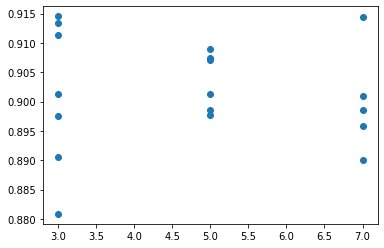

In [6]:
plt.scatter(df["config/filter_width"], df.val_auroc) 

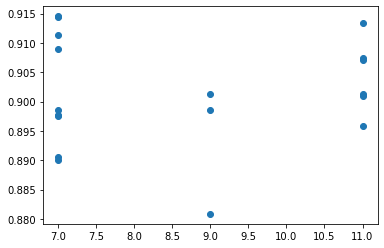

In [7]:
plt.scatter(df["config/first_filter_width"], df.val_auroc)  # 5 is too short, 9 seems good

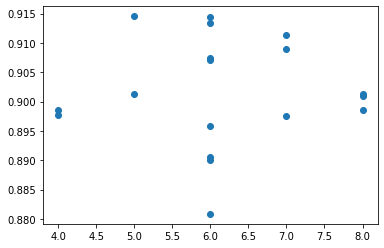

In [8]:
plt.scatter(df["config/first_pool_stride"], df.val_auroc) # at least 4

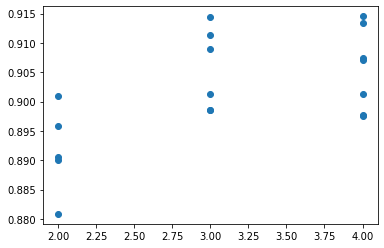

In [9]:
plt.scatter(df["config/pool_stride"], df.val_auroc)

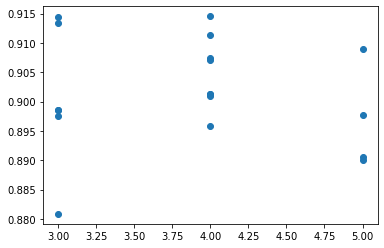

In [10]:
plt.scatter(df["config/pool_overlap"], df.val_auroc) # 4 is good, <3 is bad

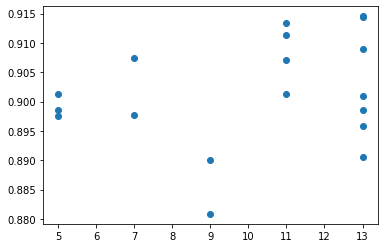

In [11]:
plt.scatter(df["config/num_chunks"], df.val_auroc) # 9 is best

In [21]:
import json
from pathlib import Path
seq_lens = []
trainer = None 
for i in range(len(df)):
    logdir = Path(df.logdir.iloc[i])
    progress = pd.read_csv(logdir / "progress.csv")
    checkpoint = logdir / ("checkpoint_%i" % (progress.val_auroc.argmax() + 1)) 
    config = json.load(open(logdir / "params.json"))
    #config["RBP"] = RBP
    #config["rep"] = rep
    if (trainer is None): 
        trainer = biophysnn_raytune.Trainable(config)
    else: 
        trainer.reset_config(config)
    seq_lens.append(trainer.model.seq_len)
df["seq_lens"] = seq_lens

Device: cpu
Receptive field: 137 Chunk size: 24 Number chunks: 13
Setting num threads
Receptive field: 153 Chunk size: 36 Number chunks: 13
Receptive field: 191 Chunk size: 64 Number chunks: 7
Receptive field: 254 Chunk size: 32 Number chunks: 13
Receptive field: 254 Chunk size: 96 Number chunks: 11
Receptive field: 254 Chunk size: 128 Number chunks: 5
Receptive field: 163 Chunk size: 96 Number chunks: 11
Receptive field: 194 Chunk size: 24 Number chunks: 13
Receptive field: 235 Chunk size: 72 Number chunks: 5
Receptive field: 172 Chunk size: 45 Number chunks: 11
Receptive field: 225 Chunk size: 54 Number chunks: 13
Receptive field: 178 Chunk size: 63 Number chunks: 11
Receptive field: 209 Chunk size: 24 Number chunks: 9
Receptive field: 184 Chunk size: 112 Number chunks: 5
Receptive field: 254 Chunk size: 96 Number chunks: 7
Receptive field: 160 Chunk size: 80 Number chunks: 13
Receptive field: 263 Chunk size: 63 Number chunks: 13
Receptive field: 101 Chunk size: 24 Number chunks: 9


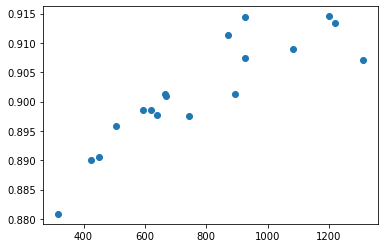

In [22]:
plt.scatter(df["seq_lens"], df.val_auroc)